In [1]:
import os

import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import yfinance as yf
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import itertools
import warnings
warnings.filterwarnings('ignore')

/var/folders/ll/22q89fv95hbb3yt5tf_x_5lc0000gp/T/ipykernel_57959/1301272536.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
import yfinance as yf

start = "2014-09-17"
end = "2024-02-14"
symbol = {"^TNX"}
df = yf.download(symbol, start, end, auto_adjust=True)

df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2024-02-07,4.125,4.125,4.065,4.110,0
2024-02-08,4.137,4.173,4.131,4.170,0
2024-02-09,4.173,4.193,4.127,4.187,0
2024-02-12,4.152,4.197,4.150,4.172,0
2024-02-13,4.152,4.316,4.150,4.316,0


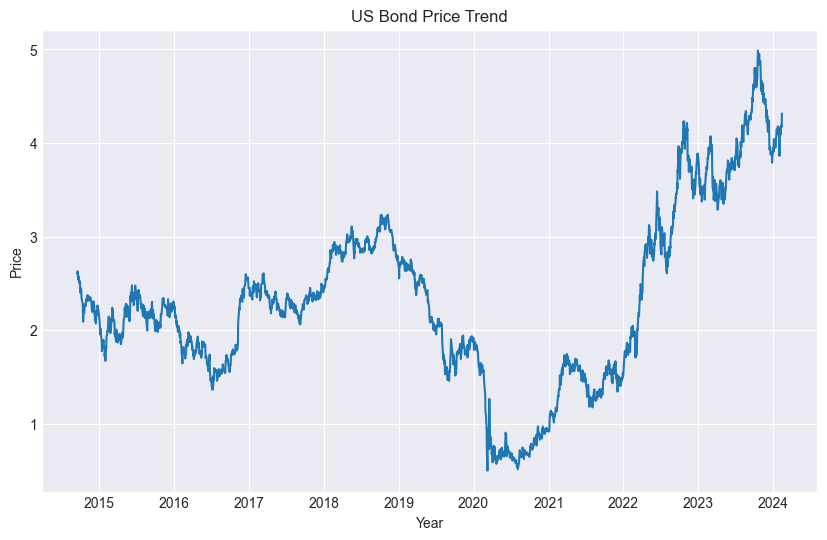

In [3]:
# Plot the time series data to understand its patterns and trends

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title("US Bond Price Trend")
plt.plot(df['Close'])

In [4]:
from statsmodels.tsa.stattools import adfuller
# If data is not stationary according to the ADF test, it has to be converted into a stationary data for building up Machine Learning Model.
# Define a function to perform the Augmented Dickey-Fuller (ADF) test

def augmented_dickey_fuller_test(timeseries):
    # Perform the ADF test
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # Print the results
    print('Results of Dickey-Fuller Test:')
    # Create a pandas Series to display the test statistics, p-value, number of lags used, and number of observations used
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    # Add critical values to the Series
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    # Print the Series containing test results
    print(dfoutput)
    
    # Determine stationarity
    if dftest[1] > 0.05:
        print("Is Stationary: No (fail to reject)")
    else:
        print("Is Stationary: Yes (reject)")

# Call the function to perform the ADF test
print(augmented_dickey_fuller_test(df['Close']))

Results of Dickey-Fuller Test:
Test Statistic                   -0.654082
p-value                           0.858288
#Lags Used                       24.000000
Number of Observations Used    2341.000000
Critical Value (1%)              -3.433146
Critical Value (5%)              -2.862775
Critical Value (10%)             -2.567428
dtype: float64
Is Stationary: No (fail to reject)
None


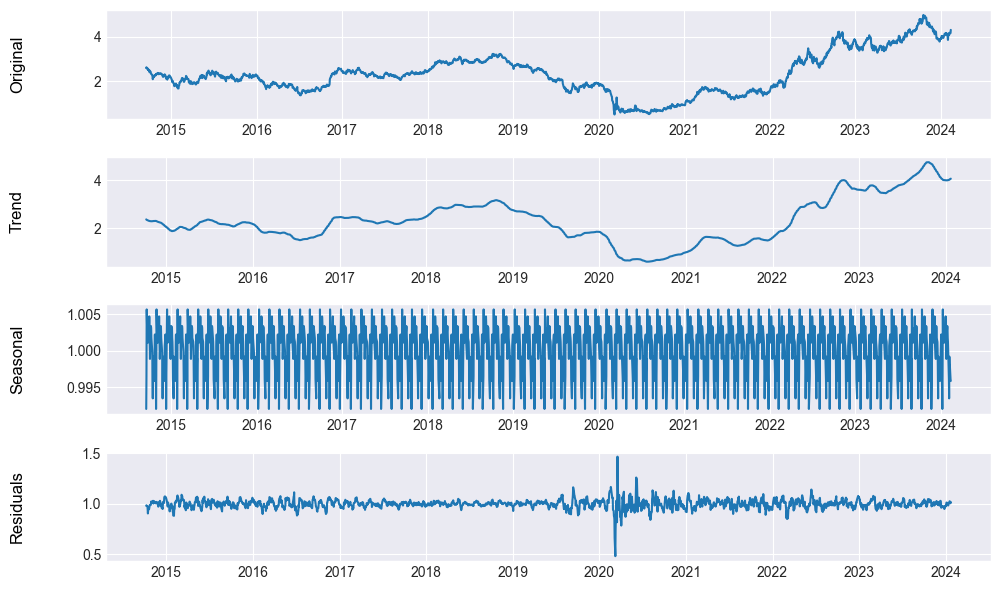

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform Time Series Data Decomposition since it helps in understanding the underlying structure and preparing the data for further analysis or modeling.

decomposition = seasonal_decompose(df["Close"], model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 6))
# Original
plt.subplot(411)
plt.plot(df["Close"], label='original')
plt.annotate('Original', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Trend
plt.subplot(412)
plt.plot(trend, label='trend')
plt.annotate('Trend', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Seasonality
plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.annotate('Seasonal', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

# Residuals
plt.subplot(414)
plt.plot(residual, label='residuals')
plt.annotate('Residuals', xy=(0, 0.5), xytext=(-0.1, 0.5), rotation='vertical',
                 ha='center', va='center', fontsize=12, color='black', xycoords='axes fraction', textcoords='axes fraction')

plt.tight_layout()
plt.show()

In [6]:
# Check the trend's staionary after decomposition : NO

trend.dropna(inplace=True)
augmented_dickey_fuller_test(trend)

Results of Dickey-Fuller Test:
Test Statistic                   -0.163230
p-value                           0.942765
#Lags Used                       24.000000
Number of Observations Used    2311.000000
Critical Value (1%)              -3.433183
Critical Value (5%)              -2.862791
Critical Value (10%)             -2.567436
dtype: float64
Is Stationary: No (fail to reject)


In [7]:
# split 8 : 2
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

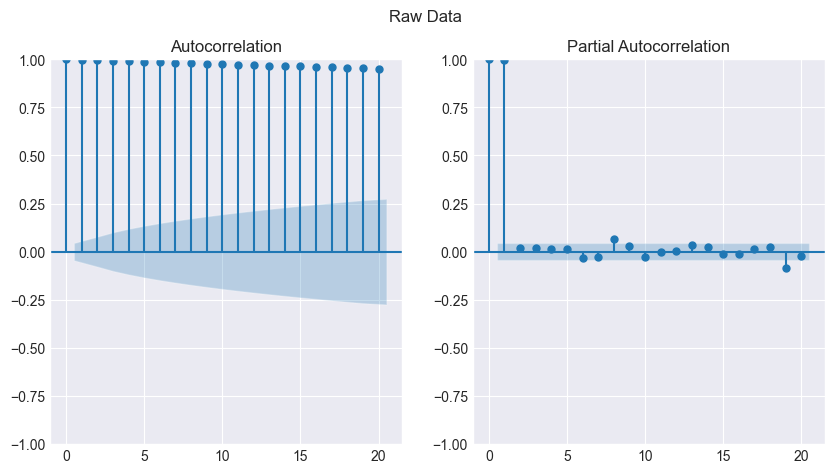

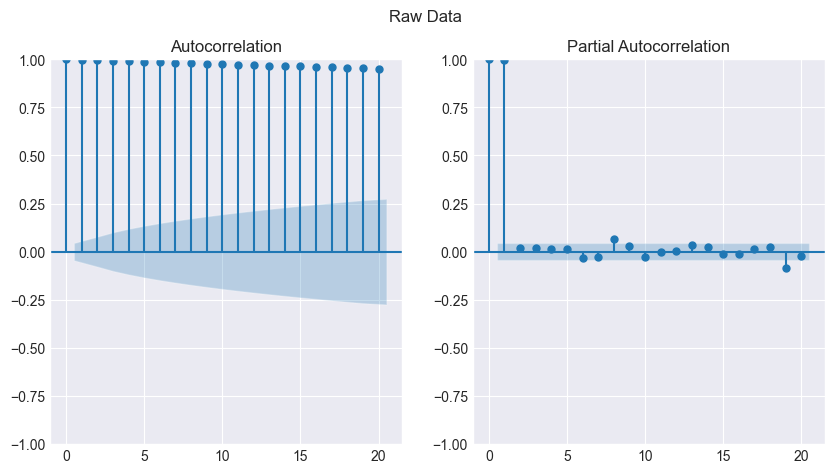

In [8]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data['Close'].values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data['Close'].values.squeeze(), lags=20, ax=ax[1])

In [9]:
# Non-stationary -> stationary 보정 (차분, difference)
# differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['Close'].diff() # 차분
diff_train_data = diff_train_data.dropna() # 차분 후 생기는 결측치 제거
print()
print(train_data['Close'].head())
print()
print(diff_train_data.head())


Date
2014-09-17    2.600
2014-09-18    2.629
2014-09-19    2.587
2014-09-22    2.566
2014-09-23    2.535
Name: Close, dtype: float64

Date
2014-09-18    0.029
2014-09-19   -0.042
2014-09-22   -0.021
2014-09-23   -0.031
2014-09-24    0.034
Name: Close, dtype: float64


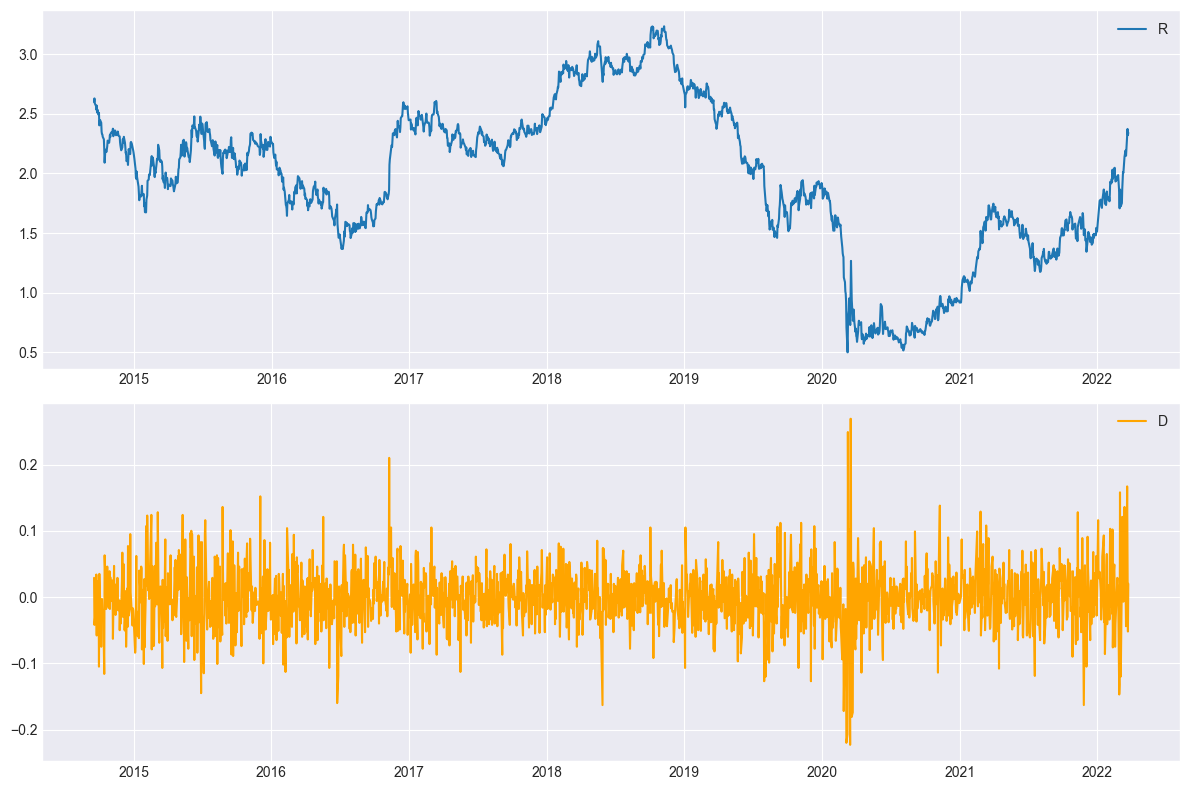

In [10]:
# 차분 시각화

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(train_data['Close'])
ax1.legend('Raw data (Non-stationary)')

ax2.plot(diff_train_data, color='orange' )
ax2.legend('Differenced data (stationary)')


plt.tight_layout()
plt.show()

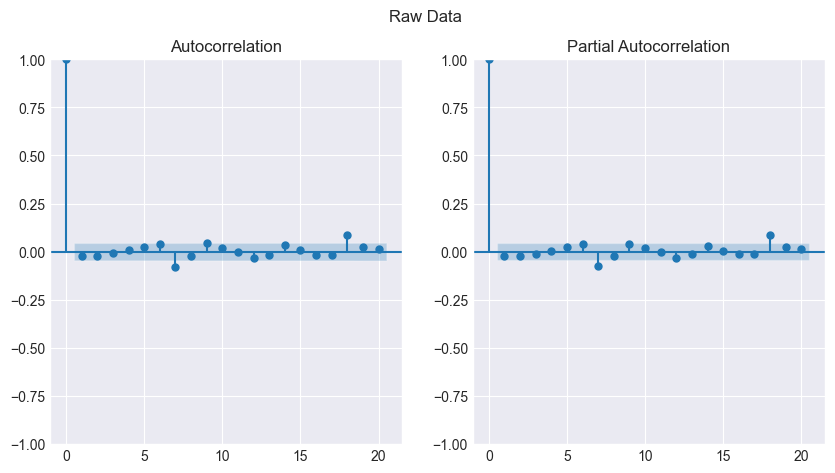

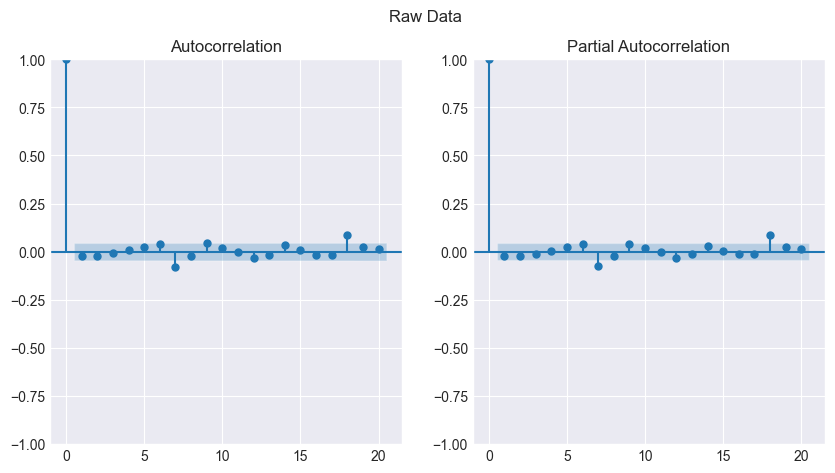

In [11]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=20, ax=ax[1])

In [12]:
# parameter search

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in pdq]

AIC = []
params = []
for i in pdq :
    for j in seasonal_pdq :
        try : 
            model = SARIMAX(train_data['Close'].values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA : {i},{j} >> AIC : {round(model_fit.aic, 2)}')
            AIC.append(round(model_fit.aic, 2))
            params.append((i, j))
            
        except Exception as e:
            print(e)
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.31172D+00    |proj g|=  3.01800D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3     31      1     0     0   4.904D-04  -1.312D+00
  F =  -1.3117211509778082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 0),(0, 1, 0, 3) >> AIC : -4961.55


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60658D+00    |proj g|=  2.25464D+00

At iterate    5    f= -1.61028D+00    |proj g|=  2.15063D-01

At iterate   10    f= -1.61838D+00    |proj g|=  3.36350D+00

At iterate   15    f= -1.65695D+00    |proj g|=  4.20486D-01

At iterate   20    f= -1.65975D+00    |proj g|=  5.85899D-03

At iterate   25    f= -1.65977D+00    |proj g|=  4.42250D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     36      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.63810D+00    |proj g|=  3.59158D-01

At iterate   10    f= -1.65943D+00    |proj g|=  7.09921D-02

At iterate   15    f= -1.66008D+00    |proj g|=  1.46256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     30      1     0     0   1.340D-05  -1.660D+00
  F =  -1.6600795458283084     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 0),(0, 1, 2, 3) >> AIC : -6275.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59436D+00    |proj g|=  1.68390D+00

At iterate    5    f= -1.59726D+00    |proj g|=  9.64444D-01

At iterate   10    f= -1.62115D+00    |proj g|=  8.90585D-01

At iterate   15    f= -1.65817D+00    |proj g|=  2.01417D-01

At iterate   20    f= -1.66009D+00    |proj g|=  3.29649D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     33      1     0     0   9.024D-04  -1.660D+00
  F =  -1.6600946814050277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH     

 This problem is unconstrained.



At iterate    5    f= -1.63442D+00    |proj g|=  2.10484D-01

At iterate   10    f= -1.64041D+00    |proj g|=  2.24119D+00

At iterate   15    f= -1.64905D+00    |proj g|=  2.53293D-01

At iterate   20    f= -1.65713D+00    |proj g|=  6.10922D-01

At iterate   25    f= -1.66002D+00    |proj g|=  3.48667D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   1.504D-03  -1.660D+00
  F =  -1.6600223695803262     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 0),(1, 1, 2, 3) >> AIC : -6273.52
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58073D+00    |proj g|=  1.04992D+00

At iterate    5    f= -1.58294D+00    |proj g|=  1.08482D+00

At iterate   10    f= -1.59361D+00    |proj g|=  7.41658D-02

At iterate   15    f= -1.60157D+00    |proj g|=  9.31907D-01

At iterate   20    f= -1.63152D+00    |proj g|=  5.49672D-01

At iterate   25    f= -1.65862D+00    |proj g|=  1.69065D-02

At iterate   30    f= -1.66032D+00    |proj g|=  6.69656D-03

At iterate   35    f= -1.66035D+00    |proj g|=  8.03847D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f= -1.63083D+00    |proj g|=  7.32589D-01

At iterate   10    f= -1.64039D+00    |proj g|=  3.88604D-01

At iterate   15    f= -1.65354D+00    |proj g|=  1.73900D+00

At iterate   20    f= -1.65974D+00    |proj g|=  1.25446D-01

At iterate   25    f= -1.66014D+00    |proj g|=  4.64636D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     37      1     0     0   8.613D-05  -1.660D+00
  F =  -1.6601449222117755     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 0),(2, 1, 2, 3) >> AIC : -6271.99
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.
 This problem is unconstrained.


SARIMA : (0, 1, 1),(0, 1, 0, 3) >> AIC : -4960.04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53614D+00    |proj g|=  6.92450D+00

At iterate    5    f= -1.61529D+00    |proj g|=  2.09337D+00

At iterate   10    f= -1.64141D+00    |proj g|=  1.79639D-01

At iterate   15    f= -1.65002D+00    |proj g|=  1.07152D+00

At iterate   20    f= -1.65996D+00    |proj g|=  1.19940D-02

At iterate   25    f= -1.65997D+00    |proj g|=  9.30939D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.63440D+00    |proj g|=  2.60865D-01

At iterate   10    f= -1.63680D+00    |proj g|=  4.31387D-01

At iterate   15    f= -1.63715D+00    |proj g|=  4.44618D-01

At iterate   20    f= -1.64898D+00    |proj g|=  1.95767D+00

At iterate   25    f= -1.65966D+00    |proj g|=  3.98357D-01

At iterate   30    f= -1.66029D+00    |proj g|=  1.12355D-02

At iterate   35    f= -1.66029D+00    |proj g|=  2.65446D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     50      1     0     0   2.610D-04  -1.660D+00
  F =  -1.6602909594439197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f= -1.47219D+00    |proj g|=  8.06432D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     42      1     0     0   7.279D-04  -1.472D+00
  F =  -1.4721867478900199     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


SARIMA : (0, 1, 1),(1, 1, 0, 3) >> AIC : -5564.75
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52844D+00    |proj g|=  6.68392D+00

At iterate    5    f= -1.59681D+00    |proj g|=  4.46799D-01

At iterate   10    f= -1.61079D+00    |proj g|=  1.03633D+00

At iterate   15    f= -1.61476D+00    |proj g|=  1.81986D+00

At iterate   20    f= -1.65372D+00    |proj g|=  1.41065D+00

At iterate   25    f= -1.66012D+00    |proj g|=  1.51718D-02

At iterate   30    f= -1.66030D+00    |proj g|=  1.71614D-02

At iterate   35    f= -1.66031D+00    |proj g|=  5.74925D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of th

 This problem is unconstrained.



At iterate    5    f= -1.63465D+00    |proj g|=  4.55845D-01

At iterate   10    f= -1.64589D+00    |proj g|=  1.51047D+00

At iterate   15    f= -1.64779D+00    |proj g|=  5.18753D-01

At iterate   20    f= -1.65563D+00    |proj g|=  8.01598D-01

At iterate   25    f= -1.65766D+00    |proj g|=  2.11637D-01

At iterate   30    f= -1.66011D+00    |proj g|=  2.15237D-01

At iterate   35    f= -1.66022D+00    |proj g|=  4.02834D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     41      1     0     0   5.535D-05  -1.660D+00
  F =  -1.6602194679818743     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.53698D+00    |proj g|=  1.54500D-02

At iterate   10    f= -1.53704D+00    |proj g|=  2.00985D-01

At iterate   15    f= -1.53710D+00    |proj g|=  5.40878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   1.787D-04  -1.537D+00
  F =  -1.5370974514617832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 1),(2, 1, 0, 3) >> AIC : -5808.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f= -1.58187D+00    |proj g|=  3.49068D-01

At iterate   10    f= -1.59538D+00    |proj g|=  1.01602D+00

At iterate   15    f= -1.61743D+00    |proj g|=  2.52280D+00

At iterate   20    f= -1.62548D+00    |proj g|=  2.36063D-01

At iterate   25    f= -1.65784D+00    |proj g|=  1.92154D-01

At iterate   30    f= -1.66049D+00    |proj g|=  5.03039D-02

At iterate   35    f= -1.66052D+00    |proj g|=  4.00052D-02

At iterate   40    f= -1.66054D+00    |proj g|=  2.22215D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     52      1     0     0   1.893D-03  -1.661D+00
  F =  -1.66053636270

 This problem is unconstrained.



At iterate    5    f= -1.63202D+00    |proj g|=  1.18352D+00

At iterate   10    f= -1.63891D+00    |proj g|=  2.11237D-01

At iterate   15    f= -1.64394D+00    |proj g|=  2.23260D+00

At iterate   20    f= -1.65911D+00    |proj g|=  9.07564D-02

At iterate   25    f= -1.65963D+00    |proj g|=  1.27553D-01

At iterate   30    f= -1.66035D+00    |proj g|=  2.90612D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     42      1     0     0   5.805D-04  -1.660D+00
  F =  -1.6603503004441109     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 1),(2, 1, 2, 3) >> AIC : -6270.77
R

 This problem is unconstrained.



At iterate   15    f= -1.33075D+00    |proj g|=  1.03889D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     24      1     0     0   6.789D-06  -1.331D+00
  F =  -1.3307500861772823     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA : (0, 1, 2),(0, 1, 0, 3) >> AIC : -5029.56
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53646D+00    |proj g|=  6.91672D+00


 This problem is unconstrained.



At iterate    5    f= -1.61041D+00    |proj g|=  2.68206D-01

At iterate   10    f= -1.62197D+00    |proj g|=  2.66059D+00

At iterate   15    f= -1.63157D+00    |proj g|=  1.93675D-01

At iterate   20    f= -1.65529D+00    |proj g|=  5.94114D-02

At iterate   25    f= -1.66019D+00    |proj g|=  1.52347D-03

At iterate   30    f= -1.66019D+00    |proj g|=  1.21093D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     40      1     0     0   6.992D-05  -1.660D+00
  F =  -1.6601923381467569     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 2),(0, 1, 1, 3) >> AIC : -6274.17
R

 This problem is unconstrained.



At iterate    5    f= -1.63438D+00    |proj g|=  3.07292D-01

At iterate   10    f= -1.63689D+00    |proj g|=  2.85578D-01

At iterate   15    f= -1.63705D+00    |proj g|=  2.68263D-01

At iterate   20    f= -1.64460D+00    |proj g|=  1.68526D+00

At iterate   25    f= -1.65315D+00    |proj g|=  2.06467D-01

At iterate   30    f= -1.65649D+00    |proj g|=  1.21263D+00

At iterate   35    f= -1.66011D+00    |proj g|=  1.70422D-01

At iterate   40    f= -1.66030D+00    |proj g|=  1.07541D-01

At iterate   45    f= -1.66046D+00    |proj g|=  3.06119D-03

At iterate   50    f= -1.66048D+00    |proj g|=  6.83987D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.47220D+00    |proj g|=  3.09583D-02

At iterate   10    f= -1.47234D+00    |proj g|=  1.17752D-01

At iterate   15    f= -1.47235D+00    |proj g|=  2.89737D-02

At iterate   20    f= -1.47237D+00    |proj g|=  7.24652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   4.389D-04  -1.472D+00
  F =  -1.4723689249110570     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 2),(1, 1, 0, 3) >> AIC : -5563.44
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0     

 This problem is unconstrained.



At iterate    5    f= -1.59680D+00    |proj g|=  4.20520D-01

At iterate   10    f= -1.61380D+00    |proj g|=  9.87423D-01

At iterate   15    f= -1.64953D+00    |proj g|=  2.41249D+00

At iterate   20    f= -1.65850D+00    |proj g|=  1.34178D-01

At iterate   25    f= -1.65937D+00    |proj g|=  3.42387D-01

At iterate   30    f= -1.66049D+00    |proj g|=  1.70211D-02

At iterate   35    f= -1.66050D+00    |proj g|=  2.97462D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     50      1     0     0   8.286D-04  -1.660D+00
  F =  -1.6604983245254461     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.63468D+00    |proj g|=  5.05317D-01

At iterate   10    f= -1.64549D+00    |proj g|=  1.08342D+00

At iterate   15    f= -1.64911D+00    |proj g|=  1.58828D+00

At iterate   20    f= -1.65632D+00    |proj g|=  7.44064D-02

At iterate   25    f= -1.65940D+00    |proj g|=  1.51199D-01

At iterate   30    f= -1.65974D+00    |proj g|=  3.70088D-02

At iterate   35    f= -1.66044D+00    |proj g|=  1.60728D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     48      1     0     0   1.515D-04  -1.660D+00
  F =  -1.6604420770519719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.53706D+00    |proj g|=  8.51478D-03

At iterate   10    f= -1.53710D+00    |proj g|=  6.48643D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   1.111D-03  -1.537D+00
  F =  -1.5370985017817431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (0, 1, 2),(2, 1, 0, 3) >> AIC : -5806.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52027D+00    |proj g|=  6.41285D+00


 This problem is unconstrained.



At iterate    5    f= -1.58185D+00    |proj g|=  3.41727D-01

At iterate   10    f= -1.59416D+00    |proj g|=  1.11264D+00

At iterate   15    f= -1.60590D+00    |proj g|=  2.98743D+00

At iterate   20    f= -1.62331D+00    |proj g|=  3.56417D-01

At iterate   25    f= -1.65415D+00    |proj g|=  4.01094D-02

At iterate   30    f= -1.65680D+00    |proj g|=  9.47847D-01

At iterate   35    f= -1.66071D+00    |proj g|=  9.37529D-03

At iterate   40    f= -1.66073D+00    |proj g|=  1.01259D-02

At iterate   45    f= -1.66073D+00    |proj g|=  6.23447D-03

At iterate   50    f= -1.66073D+00    |proj g|=  6.60086D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.63214D+00    |proj g|=  1.23430D+00

At iterate   10    f= -1.63865D+00    |proj g|=  1.04864D-01

At iterate   15    f= -1.64056D+00    |proj g|=  1.46974D+00

At iterate   20    f= -1.65647D+00    |proj g|=  4.37262D-01

At iterate   25    f= -1.65952D+00    |proj g|=  3.53396D-01

At iterate   30    f= -1.65991D+00    |proj g|=  2.55760D-02

At iterate   35    f= -1.66055D+00    |proj g|=  1.28744D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     53      1     0     0   9.557D-04  -1.661D+00
  F =  -1.6605524225645723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


SARIMA : (1, 1, 0),(0, 1, 0, 3) >> AIC : -4960.01
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53613D+00    |proj g|=  6.92623D+00

At iterate    5    f= -1.61519D+00    |proj g|=  2.09377D+00

At iterate   10    f= -1.65597D+00    |proj g|=  2.91210D-01

At iterate   15    f= -1.65972D+00    |proj g|=  1.33298D-01

At iterate   20    f= -1.65997D+00    |proj g|=  1.10010D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     34      1     0     0   4.110D-06  -

 This problem is unconstrained.



At iterate    5    f= -1.63443D+00    |proj g|=  2.53309D-01

At iterate   10    f= -1.63683D+00    |proj g|=  4.62545D-01

At iterate   15    f= -1.63740D+00    |proj g|=  6.52779D-01

At iterate   20    f= -1.65231D+00    |proj g|=  2.14294D+00

At iterate   25    f= -1.65986D+00    |proj g|=  2.08636D-01

At iterate   30    f= -1.66028D+00    |proj g|=  1.27576D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     53      1     0     0   4.461D-04  -1.660D+00
  F =  -1.6602824597275614     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 0),(0, 1, 2, 3) >> AIC : -6274.51
R

 This problem is unconstrained.


At iterate    5    f= -1.47210D+00    |proj g|=  1.68665D-02

At iterate   10    f= -1.47217D+00    |proj g|=  1.36488D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   8.741D-05  -1.472D+00
  F =  -1.4721866650457736     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 0),(1, 1, 0, 3) >> AIC : -5564.75
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52844D+00    |proj g|=  6.68606D+00


 This problem is unconstrained.



At iterate    5    f= -1.59689D+00    |proj g|=  4.53452D-01

At iterate   10    f= -1.61061D+00    |proj g|=  1.00811D+00

At iterate   15    f= -1.61305D+00    |proj g|=  1.34117D+00

At iterate   20    f= -1.64343D+00    |proj g|=  2.96051D+00

At iterate   25    f= -1.65995D+00    |proj g|=  2.08210D-01

At iterate   30    f= -1.66030D+00    |proj g|=  1.04550D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     57      1     0     0   4.641D-04  -1.660D+00
  F =  -1.6602972075961588     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 0),(1, 1, 1, 3) >> AIC : -6274.56
R


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.63469D+00    |proj g|=  4.42715D-01

At iterate   10    f= -1.64648D+00    |proj g|=  1.74635D+00

At iterate   15    f= -1.64871D+00    |proj g|=  2.44511D-01

At iterate   20    f= -1.65328D+00    |proj g|=  1.69586D+00

At iterate   25    f= -1.65999D+00    |proj g|=  7.69233D-02

At iterate   30    f= -1.66009D+00    |proj g|=  1.82175D-02

At iterate   35    f= -1.66021D+00    |proj g|=  1.97807D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     52      1     0     0   2.088D-04  -1.660D+00
  F =  -1.6602116132540454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.53709D+00    |proj g|=  3.97485D-03

At iterate   10    f= -1.53710D+00    |proj g|=  1.09069D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     18      1     0     0   1.182D-04  -1.537D+00
  F =  -1.5370972944626415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 0),(2, 1, 0, 3) >> AIC : -5808.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51996D+00    |proj g|=  6.42366D+00


 This problem is unconstrained.



At iterate    5    f= -1.58193D+00    |proj g|=  3.48630D-01

At iterate   10    f= -1.59546D+00    |proj g|=  1.01505D+00

At iterate   15    f= -1.61797D+00    |proj g|=  2.37671D+00

At iterate   20    f= -1.62557D+00    |proj g|=  1.06162D-01

At iterate   25    f= -1.65677D+00    |proj g|=  3.11084D-02

At iterate   30    f= -1.66039D+00    |proj g|=  3.26507D-02

At iterate   35    f= -1.66053D+00    |proj g|=  4.22565D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     83      2     0     0   4.226D-03  -1.661D+00
  F =  -1.6605287729728080     

ABNORMAL_TERMINATION_IN_LNSRCH                              
SARIMA : (1, 1, 0),(2, 1, 1, 3) >> AIC : -6273.44
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54681D+00    |proj g|=  7.26283D+00

At iterate    5    f= -1.63201D+00    |proj g|=  1.16785D+00

At iterate   10    f= -1.63928D+00    |proj g|=  3.14410D-01

At iterate   15    

 This problem is unconstrained.


At iterate    5    f= -1.31174D+00    |proj g|=  6.20585D-02

At iterate   10    f= -1.31184D+00    |proj g|=  5.66438D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   2.612D-04  -1.312D+00
  F =  -1.3118443236252941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 1),(0, 1, 0, 3) >> AIC : -4958.02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58035D+00    |proj g|=  5.29956D+00


 This problem is unconstrained.



At iterate    5    f= -1.61023D+00    |proj g|=  7.51354D-02

At iterate   10    f= -1.61495D+00    |proj g|=  1.99556D+00

At iterate   15    f= -1.64777D+00    |proj g|=  2.29784D+00

At iterate   20    f= -1.65940D+00    |proj g|=  3.52011D-01

At iterate   25    f= -1.65998D+00    |proj g|=  6.09564D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     46      1     0     0   2.367D-04  -1.660D+00
  F =  -1.6599763401038681     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 1),(0, 1, 1, 3) >> AIC : -6273.35
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.63424D+00    |proj g|=  4.06254D-02

At iterate   10    f= -1.63640D+00    |proj g|=  5.25273D-01

At iterate   15    f= -1.63831D+00    |proj g|=  9.44447D-01

At iterate   20    f= -1.64021D+00    |proj g|=  5.78881D-01

At iterate   25    f= -1.64855D+00    |proj g|=  1.77817D+00

At iterate   30    f= -1.65975D+00    |proj g|=  5.91270D-01

At iterate   35    f= -1.66030D+00    |proj g|=  4.13209D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     46      1     0     0   1.673D-03  -1.660D+00
  F =  -1.6602950362341971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.47218D+00    |proj g|=  3.76497D-03

At iterate   10    f= -1.47219D+00    |proj g|=  5.87715D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   8.368D-05  -1.472D+00
  F =  -1.4721866980206140     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 1),(1, 1, 0, 3) >> AIC : -5562.75
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57064D+00    |proj g|=  4.95964D+00


 This problem is unconstrained.



At iterate    5    f= -1.59652D+00    |proj g|=  2.07032D-01

At iterate   10    f= -1.60605D+00    |proj g|=  2.36839D+00

At iterate   15    f= -1.62616D+00    |proj g|=  1.14483D+00

At iterate   20    f= -1.63383D+00    |proj g|=  1.12891D+00

At iterate   25    f= -1.65666D+00    |proj g|=  3.41411D-01

At iterate   30    f= -1.66023D+00    |proj g|=  1.50558D-02

At iterate   35    f= -1.66030D+00    |proj g|=  5.27240D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     46      1     0     0   5.272D-04  -1.660D+00
  F =  -1.6603046025508408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.63449D+00    |proj g|=  8.24674D-02

At iterate   10    f= -1.64605D+00    |proj g|=  5.65279D-01

At iterate   15    f= -1.65215D+00    |proj g|=  4.91177D-02

At iterate   20    f= -1.65472D+00    |proj g|=  4.83903D-01

At iterate   25    f= -1.66019D+00    |proj g|=  4.25566D-02

At iterate   30    f= -1.66022D+00    |proj g|=  3.97154D-03

At iterate   35    f= -1.66022D+00    |proj g|=  1.35914D-02

At iterate   40    f= -1.66039D+00    |proj g|=  1.04459D-02

At iterate   45    f= -1.66041D+00    |proj g|=  1.25060D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     59   

 This problem is unconstrained.



At iterate    5    f= -1.53704D+00    |proj g|=  6.62908D-02

At iterate   10    f= -1.53710D+00    |proj g|=  1.65225D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     17      1     0     0   7.935D-05  -1.537D+00
  F =  -1.5370973521855329     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 1),(2, 1, 0, 3) >> AIC : -5806.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55991D+00    |proj g|=  4.58724D+00


 This problem is unconstrained.



At iterate    5    f= -1.58168D+00    |proj g|=  2.08694D-01

At iterate   10    f= -1.59059D+00    |proj g|=  2.00932D+00

At iterate   15    f= -1.59440D+00    |proj g|=  6.43119D-01

At iterate   20    f= -1.61246D+00    |proj g|=  3.02340D+00

At iterate   25    f= -1.63877D+00    |proj g|=  5.29343D-01

At iterate   30    f= -1.65946D+00    |proj g|=  7.04368D-02

At iterate   35    f= -1.66053D+00    |proj g|=  7.82535D-02

At iterate   40    f= -1.66054D+00    |proj g|=  1.47498D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     52      1     0     0   1.525D-03  -1.661D+00
  F =  -1.66053596887

 This problem is unconstrained.



At iterate    5    f= -1.63059D+00    |proj g|=  2.88642D-01

At iterate   10    f= -1.63829D+00    |proj g|=  4.28071D-02

At iterate   15    f= -1.63920D+00    |proj g|=  1.05279D+00

At iterate   20    f= -1.64697D+00    |proj g|=  2.31539D-01

At iterate   25    f= -1.64930D+00    |proj g|=  1.08103D+00

At iterate   30    f= -1.65893D+00    |proj g|=  1.56192D-01

At iterate   35    f= -1.65942D+00    |proj g|=  1.90134D-01

At iterate   40    f= -1.66033D+00    |proj g|=  4.02476D-02

At iterate   45    f= -1.66035D+00    |proj g|=  5.31648D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     52   

 This problem is unconstrained.



At iterate    5    f= -1.31224D+00    |proj g|=  2.44587D-02

At iterate   10    f= -1.33556D+00    |proj g|=  6.54493D-01

At iterate   15    f= -1.40212D+00    |proj g|=  1.06457D-01

At iterate   20    f= -1.41507D+00    |proj g|=  1.00752D-01

At iterate   25    f= -1.41655D+00    |proj g|=  8.57309D-03

At iterate   30    f= -1.41680D+00    |proj g|=  8.66000D-04

At iterate   35    f= -1.41685D+00    |proj g|=  7.91855D-03

At iterate   40    f= -1.41686D+00    |proj g|=  8.02501D-04

At iterate   45    f= -1.41686D+00    |proj g|=  3.98337D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     78      1     0     0   3.972D-04  -1.417D+00
  F =  -1.4168646687050266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 2),(0, 1, 0, 3) >> AIC : -5353.42
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53655D+00    |proj g|=  6.91478D+00

At iterate    5    f= -1.61040D+00    |proj g|=  2.60298D-01

At iterate   10    f= -1.62049D+00    |proj g|=  2.35327D+00

At iterate   15    

 This problem is unconstrained.



At iterate    5    f= -1.63439D+00    |proj g|=  3.12983D-01

At iterate   10    f= -1.63666D+00    |proj g|=  1.85886D-01

At iterate   15    f= -1.63689D+00    |proj g|=  3.89891D-01

At iterate   20    f= -1.64032D+00    |proj g|=  1.12780D-01

At iterate   25    f= -1.64371D+00    |proj g|=  3.31014D-01

At iterate   30    f= -1.65881D+00    |proj g|=  3.80228D-02

At iterate   35    f= -1.66011D+00    |proj g|=  2.38683D-02

At iterate   40    f= -1.66035D+00    |proj g|=  1.52499D-01

At iterate   45    f= -1.66048D+00    |proj g|=  3.36533D-03

At iterate   50    f= -1.66048D+00    |proj g|=  2.28308D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.47219D+00    |proj g|=  1.06299D-02

At iterate   10    f= -1.47223D+00    |proj g|=  1.05756D-01

At iterate   15    f= -1.47225D+00    |proj g|=  1.57235D-02

At iterate   20    f= -1.47225D+00    |proj g|=  5.62396D-03

At iterate   25    f= -1.47225D+00    |proj g|=  1.69278D-02

At iterate   30    f= -1.47239D+00    |proj g|=  5.79836D-01

At iterate   35    f= -1.48945D+00    |proj g|=  8.16010D-01

At iterate   40    f= -1.51550D+00    |proj g|=  8.20769D-01

At iterate   45    f= -1.52724D+00    |proj g|=  1.53786D-01

At iterate   50    f= -1.52953D+00    |proj g|=  4.15916D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.59679D+00    |proj g|=  4.15216D-01

At iterate   10    f= -1.61425D+00    |proj g|=  9.94015D-01

At iterate   15    f= -1.63169D+00    |proj g|=  4.59836D-01

At iterate   20    f= -1.63887D+00    |proj g|=  1.27960D+00

At iterate   25    f= -1.65774D+00    |proj g|=  5.25067D-02

At iterate   30    f= -1.66042D+00    |proj g|=  6.00127D-02

At iterate   35    f= -1.66050D+00    |proj g|=  2.06824D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     45      1     0     0   3.134D-04  -1.660D+00
  F =  -1.6604991742023851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.63495D+00    |proj g|=  7.22074D-01

At iterate   10    f= -1.64691D+00    |proj g|=  4.37821D-02

At iterate   15    f= -1.65102D+00    |proj g|=  1.80782D-01

At iterate   20    f= -1.65186D+00    |proj g|=  5.85442D-01

At iterate   25    f= -1.65808D+00    |proj g|=  3.36757D-02

At iterate   30    f= -1.65977D+00    |proj g|=  1.68471D-01

At iterate   35    f= -1.66044D+00    |proj g|=  8.83564D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     50      1     0     0   7.680D-04  -1.660D+00
  F =  -1.6604357749048813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.49328D+00    |proj g|=  5.57427D+00

At iterate    5    f= -1.53706D+00    |proj g|=  8.47970D-03

At iterate   10    f= -1.53710D+00    |proj g|=  5.30983D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     19      1     0     0   4.443D-04  -1.537D+00
  F =  -1.5370980895619764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (1, 1, 2),(2, 1, 0, 3) >> AIC : -5804.38
RUNNING THE L-BFGS-B

 This problem is unconstrained.



At iterate    5    f= -1.58185D+00    |proj g|=  3.40398D-01

At iterate   10    f= -1.59407D+00    |proj g|=  1.11796D+00

At iterate   15    f= -1.60488D+00    |proj g|=  2.86116D+00

At iterate   20    f= -1.63146D+00    |proj g|=  1.69684D+00

At iterate   25    f= -1.64785D+00    |proj g|=  1.19688D-01

At iterate   30    f= -1.65968D+00    |proj g|=  3.60699D-02

At iterate   35    f= -1.66060D+00    |proj g|=  5.21265D-02

At iterate   40    f= -1.66073D+00    |proj g|=  4.05893D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     69      1     0     0   1.189D-03  -1.661D+00
  F =  -1.66072705575


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54725D+00    |proj g|=  7.25227D+00

At iterate    5    f= -1.63219D+00    |proj g|=  1.24541D+00

At iterate   10    f= -1.63847D+00    |proj g|=  9.13039D-02

At iterate   15    f= -1.64010D+00    |proj g|=  1.32707D+00

At iterate   20    f= -1.65084D+00    |proj g|=  1.46368D-01

At iterate   25    f= -1.65562D+00    |proj g|=  1.23241D+00

At iterate   30    f= -1.65943D+00    |proj g|=  1.62036D-02

At iterate   35    f= -1.65977D+00    |proj g|=  2.25226D-01

At iterate   40    f= -1.66042D+00    |proj g|=  1.39285D-02

At iterate   45    f= -1.66055D+00    |proj g|=  2.41905D-02

At iterate   50    f= -1.66055D+00    |proj g|=  8.14074D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     11      1     0     0   8.925D-04  -1.312D+00
  F =  -1.3121131325977353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 0),(0, 1, 0, 3) >> AIC : -4959.04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53637D+00    |proj g|=  6.92508D+00

At iterate    5    f= -1.61544D+00    |proj g|=  2.10552D+00

At iterate   10    f= -1.65605D+00    |proj g|=  2.95073D-01

At iterate   15    

 This problem is unconstrained.



At iterate    5    f= -1.63459D+00    |proj g|=  2.55331D-01

At iterate   10    f= -1.63699D+00    |proj g|=  4.58635D-01

At iterate   15    f= -1.63752D+00    |proj g|=  6.10646D-01

At iterate   20    f= -1.65258D+00    |proj g|=  1.89648D+00

At iterate   25    f= -1.65878D+00    |proj g|=  2.39626D-01

At iterate   30    f= -1.66047D+00    |proj g|=  4.44977D-03

At iterate   35    f= -1.66049D+00    |proj g|=  9.07293D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     49      1     0     0   3.874D-05  -1.660D+00
  F =  -1.6604879922806777     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f= -1.47232D+00    |proj g|=  1.32736D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   1.060D-04  -1.472D+00
  F =  -1.4723369581780177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 0),(1, 1, 0, 3) >> AIC : -5563.32
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52866D+00    |proj g|=  6.68413D+00


 This problem is unconstrained.



At iterate    5    f= -1.59698D+00    |proj g|=  4.38506D-01

At iterate   10    f= -1.61127D+00    |proj g|=  1.05537D+00

At iterate   15    f= -1.61907D+00    |proj g|=  2.53433D+00

At iterate   20    f= -1.65611D+00    |proj g|=  3.60712D-01

At iterate   25    f= -1.65749D+00    |proj g|=  6.71651D-02

At iterate   30    f= -1.66049D+00    |proj g|=  4.21386D-02

At iterate   35    f= -1.66050D+00    |proj g|=  2.10887D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     44      1     0     0   2.109D-04  -1.661D+00
  F =  -1.6605023713952733     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.63487D+00    |proj g|=  4.47498D-01

At iterate   10    f= -1.64671D+00    |proj g|=  1.72114D+00

At iterate   15    f= -1.64888D+00    |proj g|=  2.54323D-01

At iterate   20    f= -1.65362D+00    |proj g|=  1.69162D+00

At iterate   25    f= -1.65948D+00    |proj g|=  3.52134D-02

At iterate   30    f= -1.66019D+00    |proj g|=  2.48767D-01

At iterate   35    f= -1.66043D+00    |proj g|=  2.60201D-03

At iterate   40    f= -1.66044D+00    |proj g|=  2.05554D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     58      1     0     0   2.799D-03  -1.660D+00
  F =  -1.66043753402

 This problem is unconstrained.



At iterate    5    f= -1.53683D+00    |proj g|=  2.27328D-02

At iterate   10    f= -1.53695D+00    |proj g|=  2.91150D-01

At iterate   15    f= -1.53710D+00    |proj g|=  4.55647D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     25      1     0     0   5.162D-04  -1.537D+00
  F =  -1.5370973891434652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 0),(2, 1, 0, 3) >> AIC : -5806.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    

 This problem is unconstrained.



At iterate    5    f= -1.58197D+00    |proj g|=  3.45614D-01

At iterate   10    f= -1.59480D+00    |proj g|=  1.06960D+00

At iterate   15    f= -1.61223D+00    |proj g|=  3.07767D+00

At iterate   20    f= -1.62854D+00    |proj g|=  1.60724D-01

At iterate   25    f= -1.65947D+00    |proj g|=  3.23854D-01

At iterate   30    f= -1.66072D+00    |proj g|=  1.04808D-02

At iterate   35    f= -1.66073D+00    |proj g|=  2.96386D-03

At iterate   40    f= -1.66073D+00    |proj g|=  8.27232D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     54      1     0     0   8.846D-05  -1.661D+00
  F =  -1.66073024861

 This problem is unconstrained.



At iterate    5    f= -1.63213D+00    |proj g|=  1.16809D+00

At iterate   10    f= -1.63957D+00    |proj g|=  3.47020D-01

At iterate   15    f= -1.64930D+00    |proj g|=  2.39070D+00

At iterate   20    f= -1.65700D+00    |proj g|=  1.56556D-01

At iterate   25    f= -1.65978D+00    |proj g|=  2.56029D-01

At iterate   30    f= -1.65996D+00    |proj g|=  2.15683D-02

At iterate   35    f= -1.66051D+00    |proj g|=  6.75712D-03

At iterate   40    f= -1.66054D+00    |proj g|=  5.08554D-03

At iterate   45    f= -1.66056D+00    |proj g|=  1.08735D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     59   

 This problem is unconstrained.



At iterate   10    f= -1.31239D+00    |proj g|=  4.46777D-02

At iterate   15    f= -1.35292D+00    |proj g|=  1.10380D-01

At iterate   20    f= -1.41423D+00    |proj g|=  1.78669D-01

At iterate   25    f= -1.42563D+00    |proj g|=  3.43922D-02

At iterate   30    f= -1.42616D+00    |proj g|=  1.01552D-02

At iterate   35    f= -1.42618D+00    |proj g|=  1.35525D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     49      1     0     0   1.355D-04  -1.426D+00
  F =  -1.4261759926950135     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 1),(0, 1, 0, 3) >> AIC : -5388.65
R

 This problem is unconstrained.



At iterate    5    f= -1.61031D+00    |proj g|=  2.28083D-01

At iterate   10    f= -1.61738D+00    |proj g|=  2.07082D+00

At iterate   15    f= -1.62565D+00    |proj g|=  1.20536D+00

At iterate   20    f= -1.64458D+00    |proj g|=  1.32505D-01

At iterate   25    f= -1.65883D+00    |proj g|=  1.40721D-01

At iterate   30    f= -1.66021D+00    |proj g|=  2.39444D-02

At iterate   35    f= -1.66021D+00    |proj g|=  7.77539D-03

At iterate   40    f= -1.66023D+00    |proj g|=  1.22256D-02

At iterate   45    f= -1.66029D+00    |proj g|=  2.78690D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     73   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.63423D+00    |proj g|=  3.75884D-02

At iterate   10    f= -1.63544D+00    |proj g|=  1.03357D+00

At iterate   15    f= -1.63654D+00    |proj g|=  1.02149D-01

At iterate   20    f= -1.63809D+00    |proj g|=  8.70946D-01

At iterate   25    f= -1.63976D+00    |proj g|=  2.97659D-01

At iterate   30    f= -1.64840D+00    |proj g|=  2.06271D+00

At iterate   35    f= -1.65966D+00    |proj g|=  3.78178D-02

At iterate   40    f= -1.66040D+00    |proj g|=  1.68637D-01

At iterate   45    f= -1.66049D+00    |proj g|=  1.57553D-03

At iterate   50    f= -1.66049D+00    |proj g|=  6.96301D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.47236D+00    |proj g|=  1.40101D-02

At iterate   10    f= -1.47276D+00    |proj g|=  2.90615D-01

At iterate   15    f= -1.49493D+00    |proj g|=  1.01332D+00

At iterate   20    f= -1.52620D+00    |proj g|=  1.85299D-01

At iterate   25    f= -1.52944D+00    |proj g|=  1.84112D-01

At iterate   30    f= -1.53129D+00    |proj g|=  2.75602D-03

At iterate   35    f= -1.53140D+00    |proj g|=  1.00523D-02

At iterate   40    f= -1.53141D+00    |proj g|=  9.24601D-03

At iterate   45    f= -1.53142D+00    |proj g|=  1.59853D-02

At iterate   50    f= -1.53143D+00    |proj g|=  1.10556D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.59679D+00    |proj g|=  4.69154D-01

At iterate   10    f= -1.61499D+00    |proj g|=  6.74076D-01

At iterate   15    f= -1.62587D+00    |proj g|=  2.13078D-01

At iterate   20    f= -1.64569D+00    |proj g|=  6.32878D-01

At iterate   25    f= -1.65973D+00    |proj g|=  2.70920D-02

At iterate   30    f= -1.66049D+00    |proj g|=  1.09848D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     41      1     0     0   6.455D-04  -1.661D+00
  F =  -1.6605023524118339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 1),(1, 1, 1, 3) >> AIC : -6271.34
R

 This problem is unconstrained.



At iterate    5    f= -1.63437D+00    |proj g|=  6.03405D-02

At iterate   10    f= -1.63684D+00    |proj g|=  1.77903D+00

At iterate   15    f= -1.64348D+00    |proj g|=  5.96935D-01

At iterate   20    f= -1.64997D+00    |proj g|=  4.42165D-01

At iterate   25    f= -1.65132D+00    |proj g|=  5.79089D-01

At iterate   30    f= -1.65783D+00    |proj g|=  4.93027D-01

At iterate   35    f= -1.65819D+00    |proj g|=  1.57819D-01

At iterate   40    f= -1.66043D+00    |proj g|=  7.66226D-02

At iterate   45    f= -1.66044D+00    |proj g|=  4.92256D-03

At iterate   50    f= -1.66045D+00    |proj g|=  2.32170D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.53704D+00    |proj g|=  7.25467D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.53710D+00    |proj g|=  4.25352D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     34      1     0     0   4.254D-04  -1.537D+00
  F =  -1.5370975359322783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 1),(2, 1, 0, 3) >> AIC : -5804.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57043D+00    |proj g|=  3.53685D+00

At iterate    5    f= -1.58197D+00    |proj g|=  4.87941D-01

At iterate   10    

 This problem is unconstrained.



At iterate    5    f= -1.63035D+00    |proj g|=  1.33012D-01

At iterate   10    f= -1.63513D+00    |proj g|=  1.92615D+00

At iterate   15    f= -1.63851D+00    |proj g|=  2.54602D-01

At iterate   20    f= -1.64335D+00    |proj g|=  1.61041D+00

At iterate   25    f= -1.64858D+00    |proj g|=  5.37149D-01

At iterate   30    f= -1.65883D+00    |proj g|=  2.59873D-01

At iterate   35    f= -1.65924D+00    |proj g|=  1.27329D-01

At iterate   40    f= -1.65995D+00    |proj g|=  3.15274D-02

At iterate   45    f= -1.66016D+00    |proj g|=  1.19575D-02

At iterate   50    f= -1.66056D+00    |proj g|=  2.14700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.31251D+00    |proj g|=  1.88838D-02

At iterate   10    f= -1.38967D+00    |proj g|=  1.11469D+00

At iterate   15    f= -1.41757D+00    |proj g|=  4.79673D-01

At iterate   20    f= -1.50537D+00    |proj g|=  5.07411D-01

At iterate   25    f= -1.50821D+00    |proj g|=  7.17461D-03

At iterate   30    f= -1.50832D+00    |proj g|=  3.00067D-01

At iterate   35    f= -1.50915D+00    |proj g|=  3.40393D-02

At iterate   40    f= -1.50931D+00    |proj g|=  3.39381D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     72      1     0     0   1.245D-02  -1.509D+00
  F =  -1.50933986679

 This problem is unconstrained.



At iterate    5    f= -1.61034D+00    |proj g|=  2.31982D-01

At iterate   10    f= -1.61890D+00    |proj g|=  2.27218D+00

At iterate   15    f= -1.62781D+00    |proj g|=  8.88365D-01

At iterate   20    f= -1.65046D+00    |proj g|=  1.39070D-01

At iterate   25    f= -1.66000D+00    |proj g|=  3.45115D-03

At iterate   30    f= -1.66016D+00    |proj g|=  3.91817D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     52      1     0     0   4.407D-04  -1.660D+00
  F =  -1.6601595315803701     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 2),(0, 1, 1, 3) >> AIC : -6270.04
R


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.63437D+00    |proj g|=  3.23340D-01

At iterate   10    f= -1.63665D+00    |proj g|=  9.69749D-02

At iterate   15    f= -1.63722D+00    |proj g|=  7.33508D-01

At iterate   20    f= -1.64007D+00    |proj g|=  5.32466D-02

At iterate   25    f= -1.64290D+00    |proj g|=  1.45130D+00

At iterate   30    f= -1.65720D+00    |proj g|=  4.76141D-02

At iterate   35    f= -1.66044D+00    |proj g|=  2.06285D-03

At iterate   40    f= -1.66050D+00    |proj g|=  2.33852D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     52      1     0     0   1.616D-04  -1.660D+00
  F =  -1.66049564988

 This problem is unconstrained.



At iterate    5    f= -1.47220D+00    |proj g|=  1.27337D-01

At iterate   10    f= -1.47236D+00    |proj g|=  1.80763D-03

At iterate   15    f= -1.47236D+00    |proj g|=  3.63975D-02

At iterate   20    f= -1.47256D+00    |proj g|=  3.54240D-02

At iterate   25    f= -1.47744D+00    |proj g|=  3.50546D-01

At iterate   30    f= -1.47844D+00    |proj g|=  3.91228D-02

At iterate   35    f= -1.48203D+00    |proj g|=  4.14308D-02

At iterate   40    f= -1.48567D+00    |proj g|=  6.89883D-02

At iterate   45    f= -1.48567D+00    |proj g|=  1.20247D-03

At iterate   50    f= -1.48567D+00    |proj g|=  2.33576D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.59674D+00    |proj g|=  3.99288D-01

At iterate   10    f= -1.61220D+00    |proj g|=  1.14207D+00

At iterate   15    f= -1.62357D+00    |proj g|=  1.24113D+00

At iterate   20    f= -1.62722D+00    |proj g|=  1.21463D+00

At iterate   25    f= -1.65427D+00    |proj g|=  1.46343D-01

At iterate   30    f= -1.66029D+00    |proj g|=  6.41813D-02

At iterate   35    f= -1.66050D+00    |proj g|=  1.28131D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     48      1     0     0   5.039D-04  -1.661D+00
  F =  -1.6605017878166790     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.63492D+00    |proj g|=  7.13086D-01

At iterate   10    f= -1.64521D+00    |proj g|=  2.69524D-01

At iterate   15    f= -1.65286D+00    |proj g|=  1.29358D-01

At iterate   20    f= -1.65414D+00    |proj g|=  3.01108D-02

At iterate   25    f= -1.66033D+00    |proj g|=  6.97826D-02

At iterate   30    f= -1.66042D+00    |proj g|=  6.62799D-03

At iterate   35    f= -1.66042D+00    |proj g|=  2.57455D-04

At iterate   40    f= -1.66043D+00    |proj g|=  3.75906D-02

At iterate   45    f= -1.66047D+00    |proj g|=  9.62632D-04

At iterate   50    f= -1.66047D+00    |proj g|=  2.72527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.53704D+00    |proj g|=  2.37486D-03

At iterate   10    f= -1.53704D+00    |proj g|=  4.37842D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     17      1     0     0   4.424D-04  -1.537D+00
  F =  -1.5370439019439106     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA : (2, 1, 2),(2, 1, 0, 3) >> AIC : -5802.17
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52084D+00    |proj g|=  6.39630D+00


 This problem is unconstrained.



At iterate    5    f= -1.58181D+00    |proj g|=  3.27304D-01

At iterate   10    f= -1.59320D+00    |proj g|=  1.23782D+00

At iterate   15    f= -1.59621D+00    |proj g|=  1.34966D+00

At iterate   20    f= -1.62101D+00    |proj g|=  1.44402D+00

At iterate   25    f= -1.64068D+00    |proj g|=  8.82700D-02

At iterate   30    f= -1.65447D+00    |proj g|=  2.36805D-01

At iterate   35    f= -1.65866D+00    |proj g|=  2.46194D-01

At iterate   40    f= -1.66055D+00    |proj g|=  9.66368D-03

At iterate   45    f= -1.66073D+00    |proj g|=  3.31043D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     64   

 This problem is unconstrained.



At iterate    5    f= -1.63237D+00    |proj g|=  1.28897D+00

At iterate   10    f= -1.63818D+00    |proj g|=  7.87917D-02

At iterate   15    f= -1.63973D+00    |proj g|=  1.23394D+00

At iterate   20    f= -1.64712D+00    |proj g|=  7.18921D-01

At iterate   25    f= -1.65827D+00    |proj g|=  1.80071D-02

At iterate   30    f= -1.66047D+00    |proj g|=  3.36758D-01

At iterate   35    f= -1.66056D+00    |proj g|=  1.06271D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     46      1     0     0   1.101D-04  -1.661D+00
  F =  -1.6605577024373201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [13]:
# optimal parameter
optim = [(params[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print(optim)

[(((0, 1, 0), (0, 1, 1, 3)), -6276.56)]


In [14]:
model = SARIMAX(train_data['Close'].values, order=optim[0][0][0], seasonal_order=optim[0][0][1])
model_fit = model.fit()

model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60658D+00    |proj g|=  2.25464D+00

At iterate    5    f= -1.61028D+00    |proj g|=  2.15063D-01

At iterate   10    f= -1.61838D+00    |proj g|=  3.36350D+00


 This problem is unconstrained.



At iterate   15    f= -1.65695D+00    |proj g|=  4.20486D-01

At iterate   20    f= -1.65975D+00    |proj g|=  5.85899D-03

At iterate   25    f= -1.65977D+00    |proj g|=  4.42250D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     36      1     0     0   4.423D-05  -1.660D+00
  F =  -1.6597677075949904     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1892
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 3)   Log Likelihood                3140.281
Date:                             Thu, 15 Feb 2024   AIC                          -6276.561
Time:                                     14:29:41   BIC                          -6265.474
Sample:                                          0   HQIC                         -6272.478
                                            - 1892                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L3       -0.9853      0.004   -245.242      0.000      -0.993      -0.977
sigma2         0.0021   4.26e-05     49.044      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):               757.41
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
pred = model_fit.get_forecast(len(test_data))
pred_val = pred.predicted_mean
pred_ub = pred.conf_int()[:, 0]
pred_lb = pred.conf_int()[:, 1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['Close'].values, pred_val)

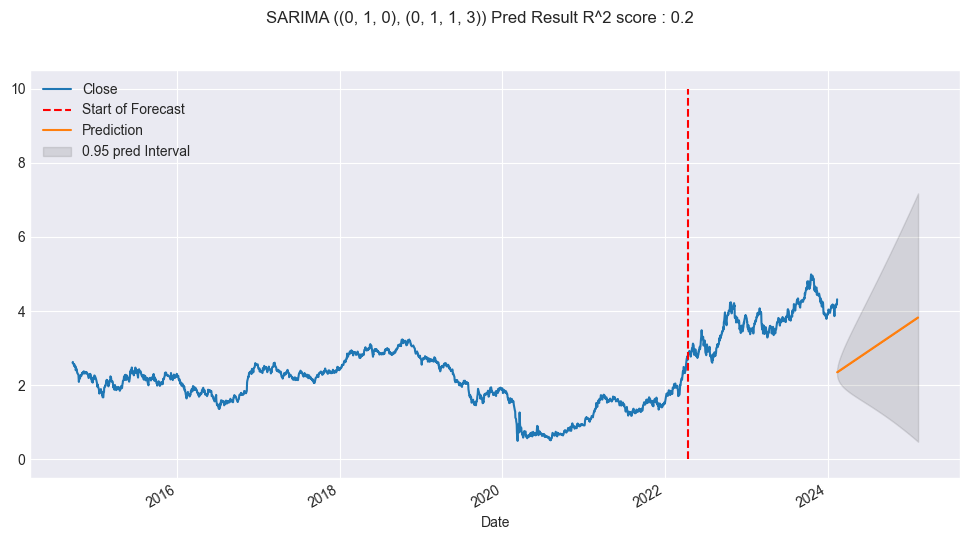

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax =ax)
ax.vlines('2022-04-15', 0, 10, linestyle='--',color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')

ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optim[0][0]} Pred Result R^2 score : {round(r2, 2)}')
plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60658D+00    |proj g|=  2.25464D+00

At iterate    5    f= -1.61028D+00    |proj g|=  2.15063D-01

At iterate   10    f= -1.61838D+00    |proj g|=  3.36350D+00

At iterate   15    f= -1.65695D+00    |proj g|=  4.20486D-01

At iterate   20    f= -1.65975D+00    |proj g|=  5.85899D-03

At iterate   25    f= -1.65977D+00    |proj g|=  4.42250D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     36      1     0     0   

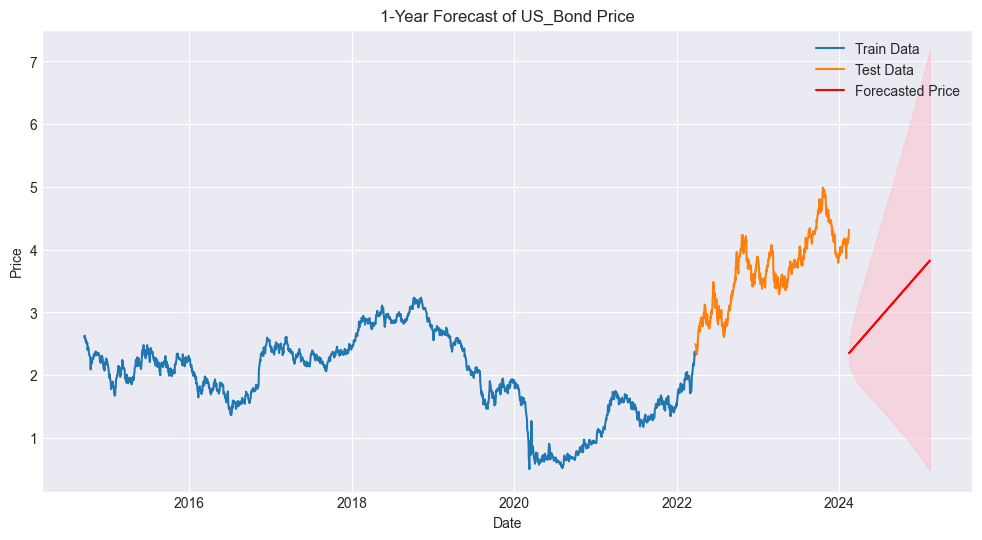

In [17]:
model = SARIMAX(train_data['Close'].values, order=optim[0][0][0], seasonal_order=optim[0][0][1])
model_fit = model.fit()
model_fit.summary()

# 1년 후의 가격 예측
forecast_period = 365  # 1년에 해당하는 일수
pred = model_fit.get_forecast(steps=forecast_period)
pred_val = pred.predicted_mean
pred_ub = pred.conf_int()[:, 0]
pred_lb = pred.conf_int()[:, 1]

# 예측 인덱스 생성
pred_index = pd.date_range(start=test_data.index[-1], periods=forecast_period, freq='D')

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Close'], label='Train Data')
plt.plot(test_data.index, test_data['Close'], label='Test Data')
plt.plot(pred_index, pred_val, color='red', label='Forecasted Price')
plt.fill_between(pred_index, pred_lb, pred_ub, color='pink', alpha=0.5)
plt.title('One-Year Forecast of 10Y US Bond Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [18]:
# Current stock price
current_price = test_data.iloc[-1]['Close']

# Stock price one year later
future_price = pred_val[-1]

# Calculate the profit rate
profit_rate = ((future_price - current_price) / current_price) * 100

print(f"Current US_Bond price: {current_price}")
print(f"Estimated US_Bond price one year later: {future_price}")
print(f"One-year profit rate: {profit_rate:.2f}%")

Current US_Bond price: 4.315999984741211
Estimated US_Bond price one year later: 3.824807404172008
One-year profit rate: -11.38%
